Using device: cpu
Loading a sample of data...

Data structure:
Type of data: <class 'numpy.ndarray'>
Shape of data: (2, 2297)

Sample 10x10 matrix:
[[3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]]

Matrix values:
Min value: 0.0
Max value: 3.0
Mean value: 0.11
Loading data from folder...
Found 4 pickle files
Original labels: [  11.   13.  211.  321. 2212.]
Mapped labels: [0, 1, 2, 3, 4]
Training samples: 8138
Validation samples: 905
Visualizing sample with label: 211.0


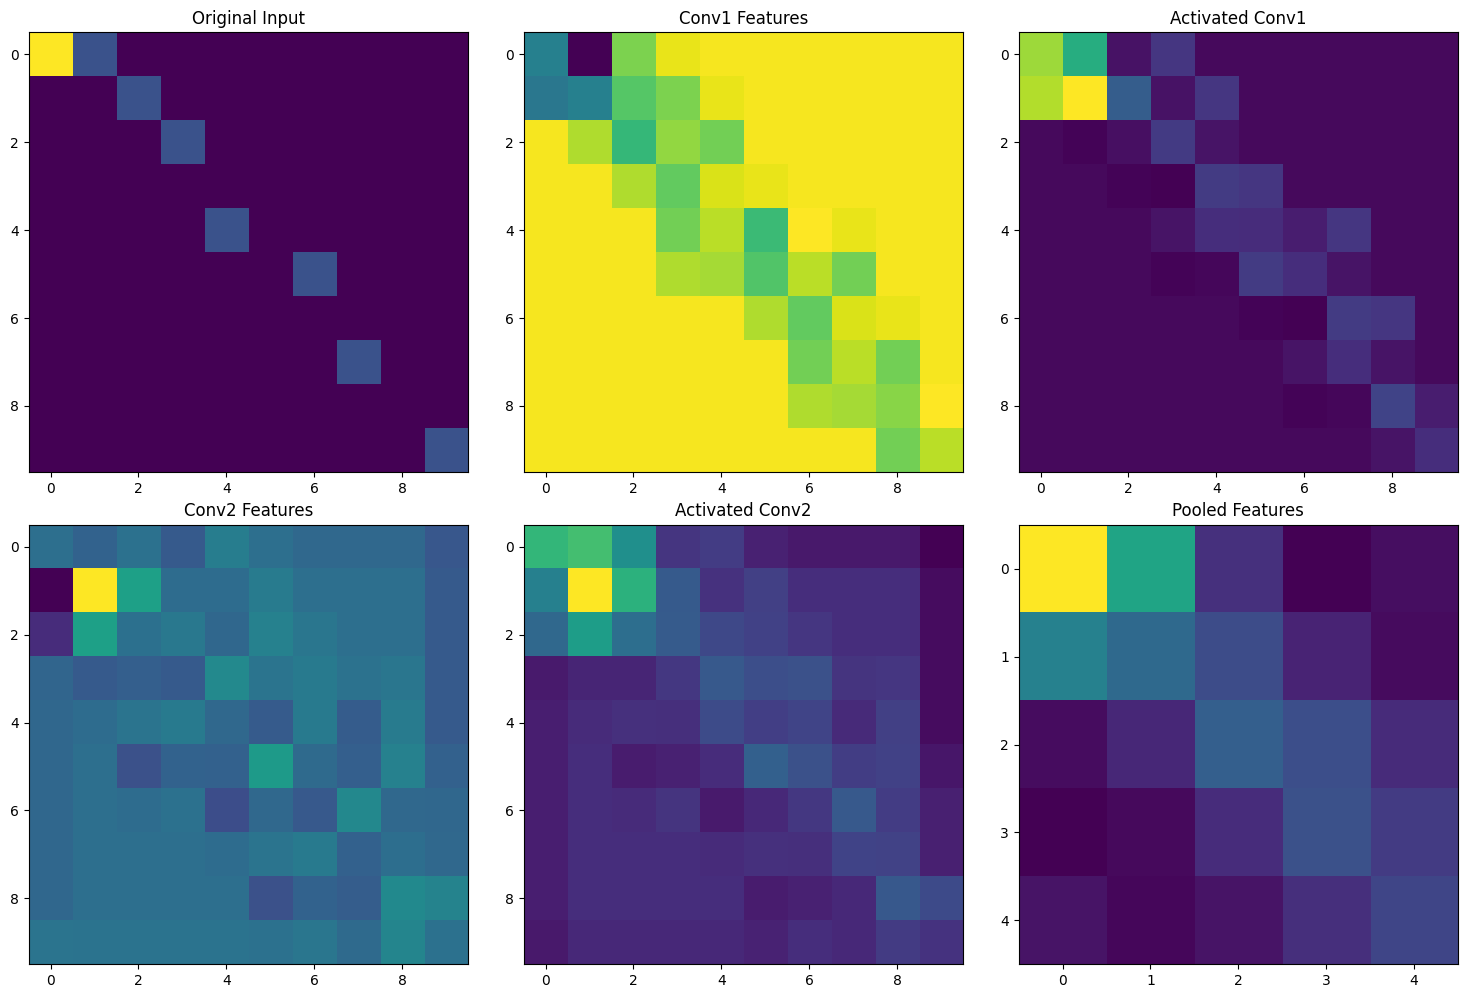

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch [1/20]

Per-class Accuracy:
Class 0 (11.0): 34.62% (9/26)
Class 1 (13.0): 20.00% (2/10)
Class 2 (211.0): 17.23% (1076/6244)
Class 3 (321.0): 22.78% (251/1102)
Class 4 (2212.0): 20.11% (152/756)

Validation Accuracy: 0.11%

Epoch [2/20]

Per-class Accuracy:
Class 0 (11.0): 50.00% (13/26)
Class 1 (13.0): 100.00% (10/10)
Class 2 (211.0): 12.43% (776/6244)
Class 3 (321.0): 19.96% (220/1102)
Class 4 (2212.0): 24.21% (183/756)

Validation Accuracy: 8.73%

Epoch [3/20]

Per-class Accuracy:
Class 0 (11.0): 76.92% (20/26)
Class 1 (13.0): 100.00% (10/10)
Class 2 (211.0): 13.76% (859/6244)
Class 3 (321.0): 16.70% (184/1102)
Class 4 (2212.0): 24.47% (185/756)

Validation Accuracy: 8.40%

Epoch [4/20]

Per-class Accuracy:
Class 0 (11.0): 80.77% (21/26)
Class 1 (13.0): 100.00% (10/10)
Class 2 (211.0): 14.29% (892/6244)
Class 3 (321.0): 22.41% (247/1102)
Class 4 (2212.0): 25.79% (195/756)

Validation Accuracy: 24.53%

Epoch [5/20]

Per-class Accuracy:
Class 0 (11.0): 88.46% (23/26)
Class 1 (13

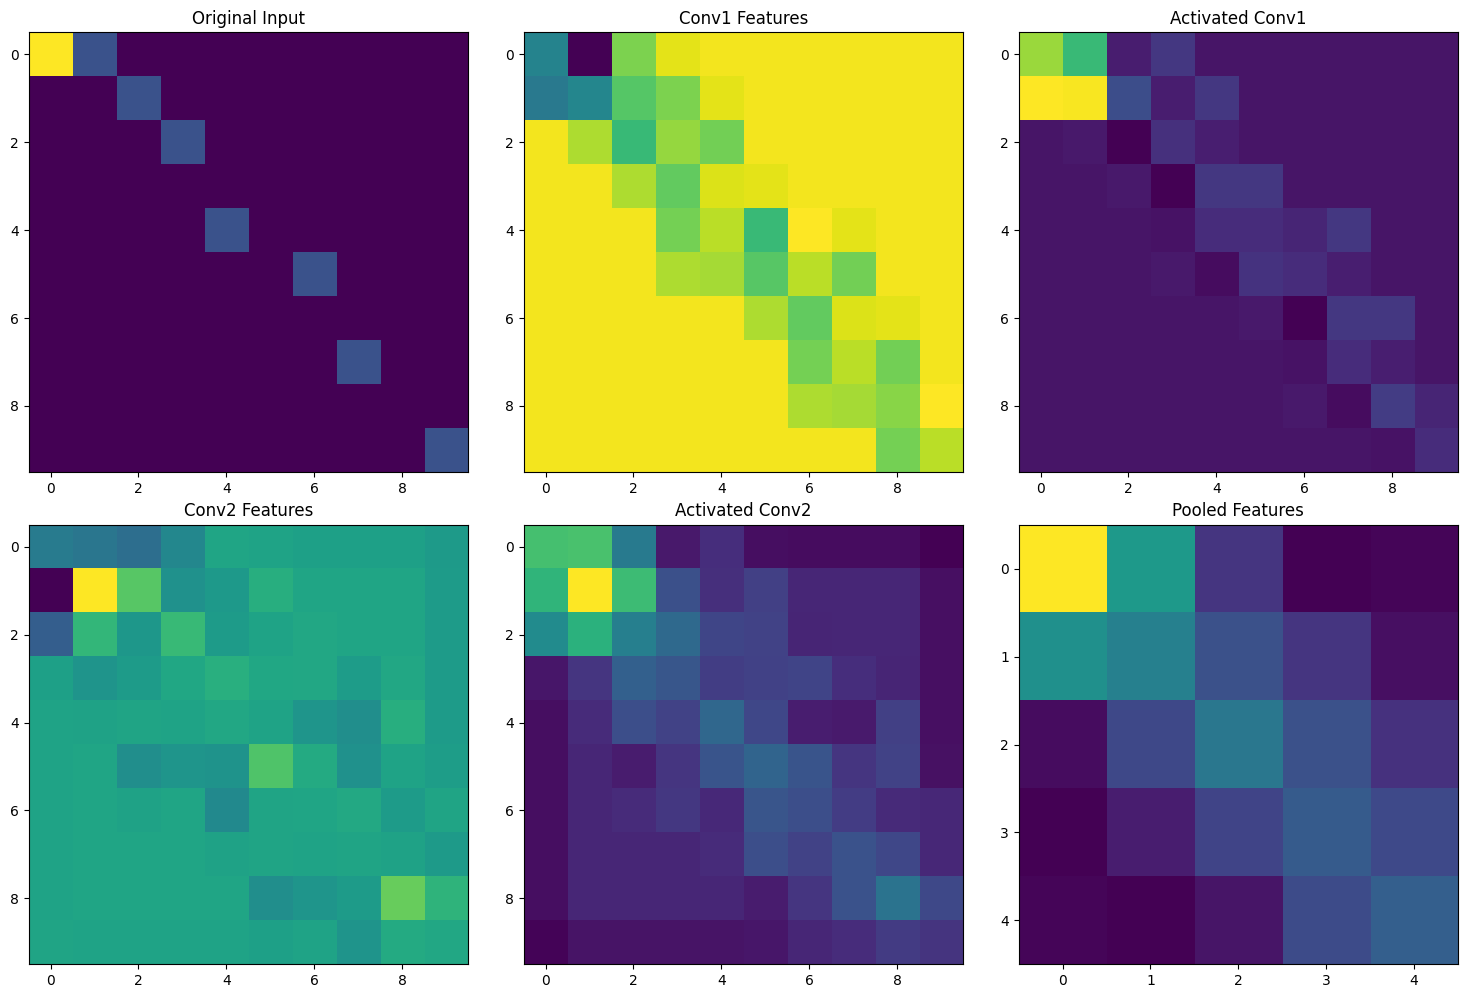

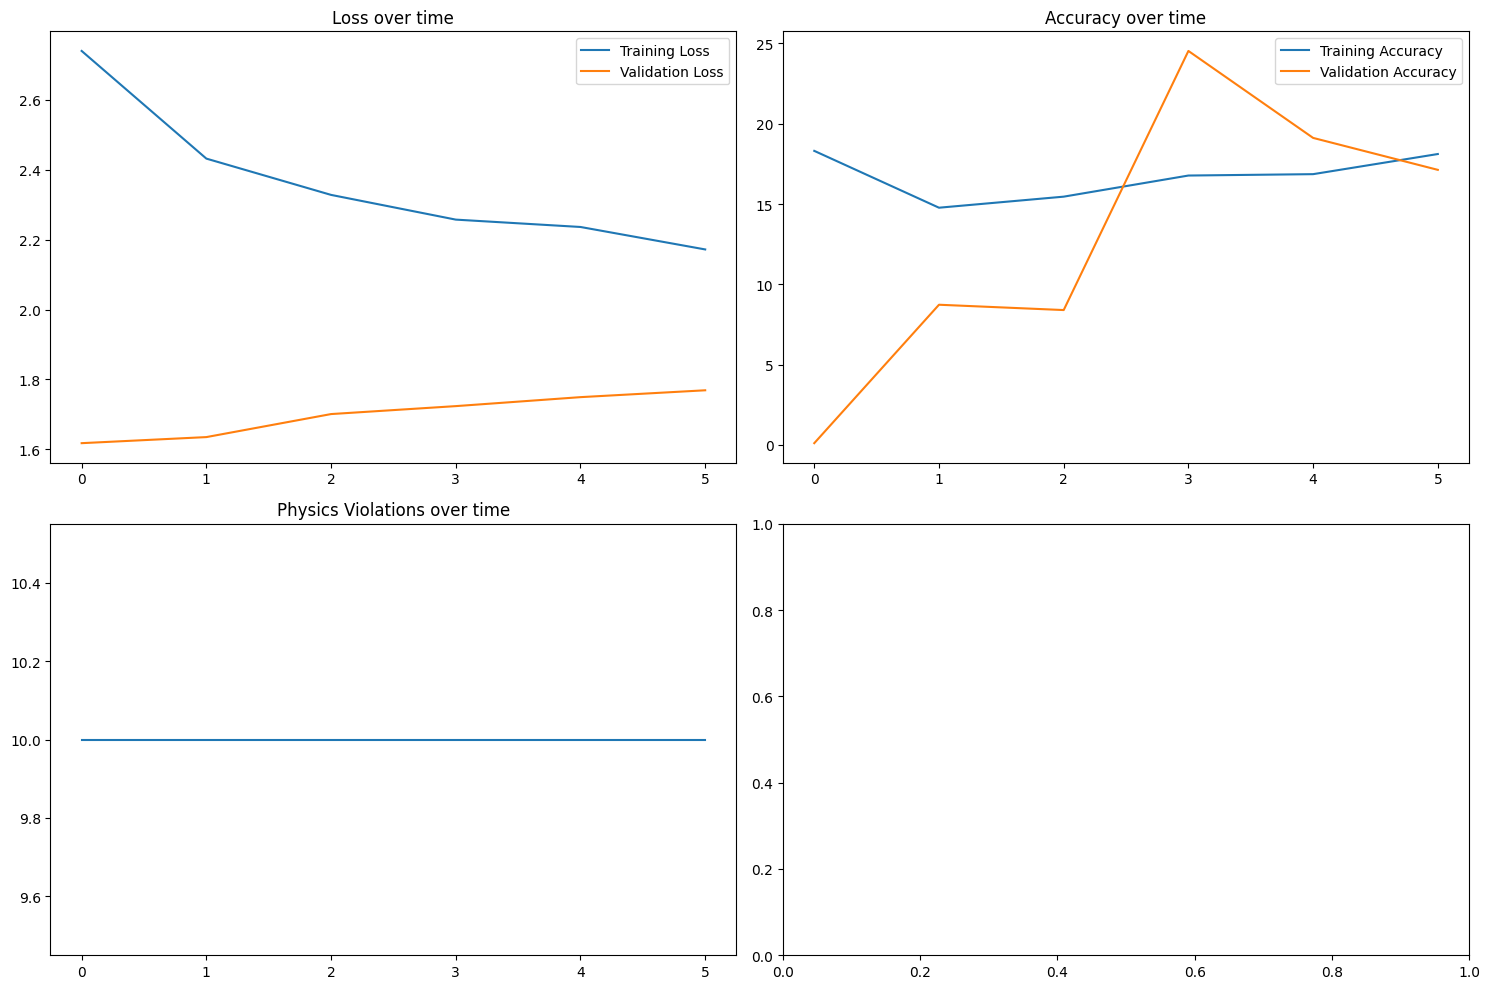

In [20]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os                                     # Add this for file operations
import pickle                                 # Add this for loading pickle files
from sklearn.model_selection import train_test_split  # Add this for data splitting
import torchvision 

class ParticlePhysicsModel(nn.Module):
    def __init__(self, input_dim=100):
        super(ParticlePhysicsModel, self).__init__()
        
        # Reshape layer to convert flat input back to 2D
        self.input_reshape = lambda x: x.view(-1, 1, 10, 10)
        
        # Define individual layers for easier access
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2)
        
        # Calculate flattened size
        self._to_linear = 64 * 5 * 5
        
        # Rest of the layers remain the same
        self.feature_extractor = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2)
        )
        
        self.trajectory_branch = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        
        self.energy_branch = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        
        self.physics_combine = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )
        
        self.classifier = nn.Linear(64, 5)

    def forward(self, x):
        # Reshape input to 2D
        x = self.input_reshape(x)
        
        # Convolutional layers
        x = self.bn1(self.relu1(self.conv1(x)))
        x = self.bn2(self.relu2(self.conv2(x)))
        x = self.pool(x)
        
        # Flatten
        flat = x.view(x.size(0), -1)
        
        # Extract high-level features
        features = self.feature_extractor(flat)
        
        # Process through physical branches
        trajectory_features = self.trajectory_branch(features)
        energy_features = self.energy_branch(features)
        
        # Combine physical information
        combined = torch.cat([trajectory_features, energy_features], dim=1)
        physics_features = self.physics_combine(combined)
        
        # Final classification
        output = self.classifier(physics_features)
        
        return output, features

    def get_feature_maps(self, x):
        """Method to extract intermediate feature maps for visualization"""
        x = self.input_reshape(x)
        
        features = {}
        
        # Input
        features['input'] = x
        
        # First conv layer
        conv1_out = self.conv1(x)
        features['conv1'] = conv1_out
        
        # After first activation
        conv1_activated = self.bn1(self.relu1(conv1_out))
        features['conv1_activated'] = conv1_activated
        
        # Second conv layer
        conv2_out = self.conv2(conv1_activated)
        features['conv2'] = conv2_out
        
        # After second activation
        conv2_activated = self.bn2(self.relu2(conv2_out))
        features['conv2_activated'] = conv2_activated
        
        # After pooling
        pooled = self.pool(conv2_activated)
        features['pooled'] = pooled
        
        return features
    
def visualize_feature_maps(model, sample_input, device):
    """Visualize feature maps at different levels"""
    model.eval()
    with torch.no_grad():
        x = torch.FloatTensor(sample_input).unsqueeze(0).to(device)
        feature_maps = model.get_feature_maps(x)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original input
    axes[0,0].imshow(sample_input.reshape(10, 10), cmap='viridis')
    axes[0,0].set_title('Original Input')
    
    # First conv layer features
    conv1_features = feature_maps['conv1'][0].mean(dim=0).cpu()
    axes[0,1].imshow(conv1_features.detach(), cmap='viridis')
    axes[0,1].set_title('Conv1 Features')
    
    # Activated conv1 features
    conv1_act_features = feature_maps['conv1_activated'][0].mean(dim=0).cpu()
    axes[0,2].imshow(conv1_act_features.detach(), cmap='viridis')
    axes[0,2].set_title('Activated Conv1')
    
    # Second conv layer features
    conv2_features = feature_maps['conv2'][0].mean(dim=0).cpu()
    axes[1,0].imshow(conv2_features.detach(), cmap='viridis')
    axes[1,0].set_title('Conv2 Features')
    
    # Activated conv2 features
    conv2_act_features = feature_maps['conv2_activated'][0].mean(dim=0).cpu()
    axes[1,1].imshow(conv2_act_features.detach(), cmap='viridis')
    axes[1,1].set_title('Activated Conv2')
    
    # Pooled features
    pooled_features = feature_maps['pooled'][0].mean(dim=0).cpu()
    axes[1,2].imshow(pooled_features.detach(), cmap='viridis')
    axes[1,2].set_title('Pooled Features')
    
    plt.tight_layout()
    plt.show()

def get_spatial_features(self, x):
        """Method to extract and visualize spatial features"""
        x = self.input_reshape(x)
        return self.spatial_features(x)

def get_feature_maps(self, x):
        """Method to extract intermediate feature maps for visualization"""
        x = self.input_reshape(x)
        
        # Get features from different levels
        features = {
            'input': x,
            'conv1': self.conv_features[0:4](x),
            'conv2': self.conv_features[4:8](self.conv_features[0:4](x)),
            'conv3': self.conv_features[8:](self.conv_features[0:8](x)),
            'energy': self.energy_path(x)
        }
        
        return features


def analyze_features(model, dataloader, device):
    """Analyze which features are most important for each particle type"""
    feature_importance = torch.zeros(100, 5).to(device)  # 100 features, 5 particle types
    
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            _, features = model(batch_X)
            
            # Calculate feature importance using gradient-based approach
            for i in range(5):
                mask = (batch_y == i)
                if mask.any():
                    feature_importance[:, i] += torch.abs(features[mask]).mean(dim=0)
    
    return feature_importance.cpu().numpy()

def validate_model(model, val_loader, device):
    """
    Validates the model on validation data and returns accuracy
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch_X, batch_y in val_loader:
            # Move data to correct device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass
            outputs, _ = model(batch_X)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    return correct / total  # Return accuracy as a fraction

def visualize_sample(X, y, model, device):
    """Visualize a sample and its features"""
    plt.figure(figsize=(15, 5))
    
    # Original input
    plt.subplot(131)
    sample = X[0].reshape(10, 10)
    plt.imshow(sample, cmap='viridis')
    plt.title(f'Original Input\nClass: {[11.0, 13.0, 211.0, 321.0, 2212.0][int(y[0])]}')
    plt.colorbar()
    
    # Spatial features
    with torch.no_grad():
        model.eval()
        x_tensor = torch.FloatTensor(X[0:1]).to(device)
        spatial_features = model.get_spatial_features(x_tensor)
        
    # Show first 6 feature maps
    plt.subplot(132)
    feature_grid = torchvision.utils.make_grid(
        spatial_features[0][:6].cpu(), 
        nrow=3, 
        normalize=True
    )
    plt.imshow(feature_grid.permute(1, 2, 0))
    plt.title('Spatial Features\n(First 6 channels)')
    
    # Show activation heatmap
    plt.subplot(133)
    feature_sum = spatial_features[0].sum(dim=0).cpu()
    plt.imshow(feature_sum, cmap='hot')
    plt.title('Feature Activation\nHeatmap')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

def train_with_physics(model, train_loader, val_loader, epochs=20, device='cpu'):
    """Trains the model while enforcing physics constraints"""
    
    # Initialize training stats dictionary
    training_stats = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'physics_violations': []
    }
    
    # Calculate class weights
    class_counts = torch.tensor([26, 10, 6047, 1323, 732])
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()
    class_weights = class_weights.to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    momentum_weight = 0.1
    energy_weight = 0.1
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    
    class_accuracies = {i: [] for i in range(5)}
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        physics_violations = 0
        class_correct = {i: 0 for i in range(5)}
        class_total = {i: 0 for i in range(5)}
        
        # Training loop
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs, features = model(batch_X)
            
            class_loss = criterion(outputs, batch_y)
            
            momentum_conservation = torch.clamp(
                torch.abs(features.sum(dim=1)).mean(),
                min=0, max=5
            )
            energy_conservation = torch.clamp(
                torch.abs(torch.pow(features, 2).sum(dim=1) - 1).mean(),
                min=0, max=5
            )
            
            total_loss = class_loss + \
                        momentum_weight * momentum_conservation + \
                        energy_weight * energy_conservation
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_loss += total_loss.item()
            physics_violations += (momentum_conservation.item() + energy_conservation.item())
            
            _, predicted = torch.max(outputs.data, 1)
            for i in range(5):
                mask = (batch_y == i)
                class_total[i] += mask.sum().item()
                class_correct[i] += (predicted[mask] == batch_y[mask]).sum().item()
        
        # Validation loop
        model.eval()
        epoch_val_loss = 0
        val_acc = validate_model(model, val_loader, device)
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs, _ = model(batch_X)
                epoch_val_loss += criterion(outputs, batch_y).item()
        
        # Store statistics
        training_stats['train_loss'].append(epoch_train_loss / len(train_loader))
        training_stats['val_loss'].append(epoch_val_loss / len(val_loader))
        training_stats['train_acc'].append(100 * sum(class_correct.values()) / sum(class_total.values()))
        training_stats['val_acc'].append(100 * val_acc)
        training_stats['physics_violations'].append(physics_violations / len(train_loader))
        
        # Print epoch statistics
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        print("\nPer-class Accuracy:")
        for i in range(5):
            if class_total[i] > 0:
                acc = 100 * class_correct[i] / class_total[i]
                class_accuracies[i].append(acc)
                print(f"Class {i} ({[11.0, 13.0, 211.0, 321.0, 2212.0][i]}): {acc:.2f}% ({class_correct[i]}/{class_total[i]})")
        
        print(f"\nValidation Accuracy: {100 * val_acc:.2f}%")
        
        # Early stopping check
        min_class_acc = min([acc[-1] for acc in class_accuracies.values() if len(acc) > 0])
        if min_class_acc > best_val_acc:
            best_val_acc = min_class_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
        
        scheduler.step(epoch_val_loss)
    
    return training_stats, class_accuracies

def plot_training_results(stats):
    """Plot training statistics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    axes[0,0].plot(stats['train_loss'], label='Training Loss')
    axes[0,0].plot(stats['val_loss'], label='Validation Loss')
    axes[0,0].set_title('Loss over time')
    axes[0,0].legend()
    
    # Plot accuracy
    axes[0,1].plot(stats['train_acc'], label='Training Accuracy')
    axes[0,1].plot(stats['val_acc'], label='Validation Accuracy')
    axes[0,1].set_title('Accuracy over time')
    axes[0,1].legend()
    
    # Plot physics violations
    axes[1,0].plot(stats['physics_violations'])
    axes[1,0].set_title('Physics Violations over time')
    
    plt.tight_layout()
    plt.show()

def prepare_data(folder_path, batch_size=1024):
    """Prepares data loaders from pickle files"""
    print("Loading data from folder...")
    
    # Get list of all pickle files in the folder
    pickle_files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]
    print(f"Found {len(pickle_files)} pickle files")
    
    # Load each pickle file and store in list
    all_data = []
    for file_name in pickle_files:
        full_path = os.path.join(folder_path, file_name)
        with open(full_path, 'rb') as f:
            data = pickle.load(f)           
            all_data.append(data)           
    
    # Combine all data into single arrays
    combined_data = np.concatenate(all_data, axis=1)
    X = np.array([x.flatten() for x in combined_data[0]], dtype=np.float32)
    y = combined_data[1].astype(np.float32)
    
    # Convert labels to consecutive integers starting from 0
    unique_labels = np.unique(y)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    y_mapped = np.array([label_map[label] for label in y])
    
    print("Original labels:", unique_labels)
    print("Mapped labels:", list(label_map.values()))
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_mapped,              # Use mapped labels
        test_size=0.1,
        random_state=42,
        stratify=y_mapped        # Ensure balanced split
    )
    
    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.LongTensor(y_train)    # Must be LongTensor for classification
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.LongTensor(y_val)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    
    return train_loader, val_loader, len(unique_labels)

# Update the main execution block
if __name__ == "__main__":
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data loaders and inspect data
    folder_path = "/Users/geoff/Desktop/Particle Dynamics Predictor Folder/archive"
    sample_data = inspect_data(folder_path)
    train_loader, val_loader, num_classes = prepare_data(folder_path)
    
    # Get a sample from the data loader
    for batch_X, batch_y in train_loader:
        sample_input = batch_X[0].numpy()  # Get first sample from first batch
        sample_label = batch_y[0].item()
        break
    
    # Create model
    model = ParticlePhysicsModel(input_dim=100).to(device)
    
    # Visualize initial feature maps
    print(f"Visualizing sample with label: {[11.0, 13.0, 211.0, 321.0, 2212.0][sample_label]}")
    visualize_feature_maps(model, sample_input, device)
    
    # Train model
    training_stats, class_accuracies = train_with_physics(model, train_loader, val_loader, device=device)
    
    # Visualize final feature maps
    visualize_feature_maps(model, sample_input, device)
    
    # Plot training results
    plot_training_results(training_stats)
def inspect_data(folder_path):
    """Examine what's in our pickle files"""
    print("Loading a sample of data...")
    
    # Load one pickle file
    pickle_files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]
    first_file = os.path.join(folder_path, pickle_files[0])
    
    with open(first_file, 'rb') as f:
        data = pickle.load(f)
        
    print("\nData structure:")
    print(f"Type of data: {type(data)}")
    print(f"Shape of data: {data.shape if hasattr(data, 'shape') else 'No shape'}")
    
    # Look at one 10x10 matrix
    if len(data) > 0:
        print("\nSample 10x10 matrix:")
        print(data[0][0])  # Assuming this is a 10x10 matrix
        print("\nMatrix values:")
        print(f"Min value: {np.min(data[0][0])}")
        print(f"Max value: {np.max(data[0][0])}")
        print(f"Mean value: {np.mean(data[0][0])}")
        
    return data

